# Regressão Linear para Previsão de Custos Médicos

Objetivo: Analisar dataset e montar um modelo preditivo de regressão para prever o valor dos custos médicos indivuais cobrados pelo seguro saúde.

Grupo: 

André Jackson Gomes Bessa - RM356320 - andrebessa@gmail.com
Guilherme Silva - RM354130 - s.guisanto079@gmail.com
Jose Eduardo - RM355857 - jeduardo.miranda@gmail.com
Thiago - RM353588 - thiagodesa26@gmail.com

In [332]:
# Para plotar graficos no jupyter sem prescisar chamar plt.show()
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import numpy as np
import warnings

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Suprimir warnings
warnings.filterwarnings("ignore")

# Seed para geração de números aleatórios
np.random.seed(42)

# Configurações globais dos gráficos
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

data_frame = pd.read_csv("insurance.csv")

## Análise Exploratória de Dados

In [333]:
data_frame.shape

(1338, 7)

In [334]:
data_frame = data_frame.drop_duplicates()

data_frame.shape

(1337, 7)

In [335]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


1337 registros, todos não nulos, temos três tipos diferentes de dados categóricos ["sex", "smoker", "region"]

In [336]:
print("Valores para sexo: " + str(set(data_frame["sex"]))) 
print("Valores para região: " + str(set(data_frame["region"]))) 
print("Valores para tabagismo: " + str(set(data_frame["smoker"]))) 

Valores para sexo: {'female', 'male'}
Valores para região: {'southwest', 'northwest', 'southeast', 'northeast'}
Valores para tabagismo: {'no', 'yes'}


<Axes: xlabel='smoker', ylabel='count'>

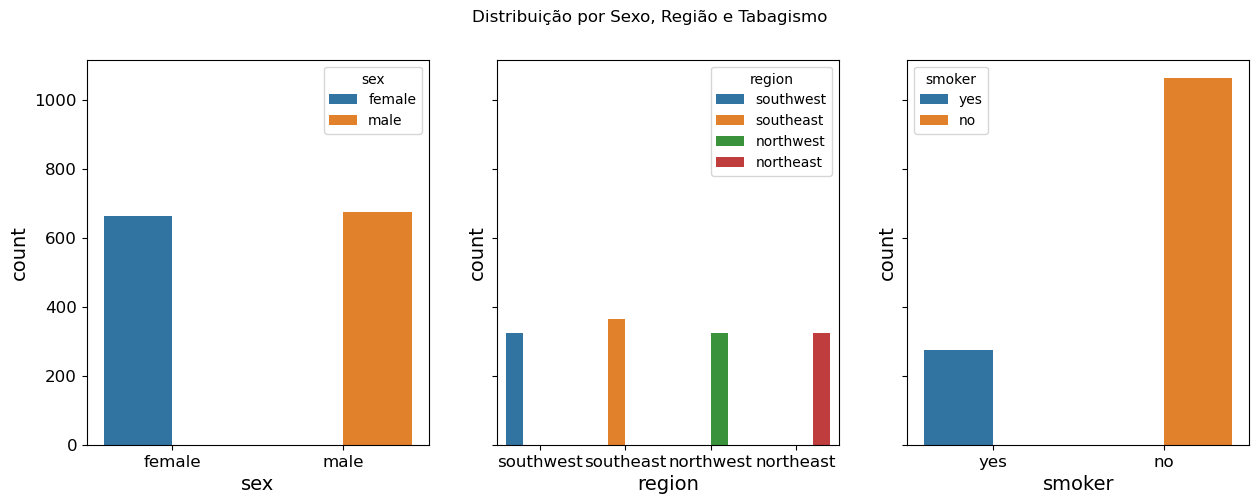

In [337]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('Distribuição por Sexo, Região e Tabagismo')
sns.countplot(x='sex', hue="sex", data=data_frame, ax=axes[0])
sns.countplot(x='region', hue="region", data=data_frame, ax=axes[1])
sns.countplot(x='smoker', hue="smoker", data=data_frame, ax=axes[2])

A base tem um pouco mais de homens que de mulheres. A distribuição por região aparente ter um pouco mais de pessoas em southeast que nas outras regiões. Temos bem mais não fumantes que fumantes 

In [338]:
data_frame["region"].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

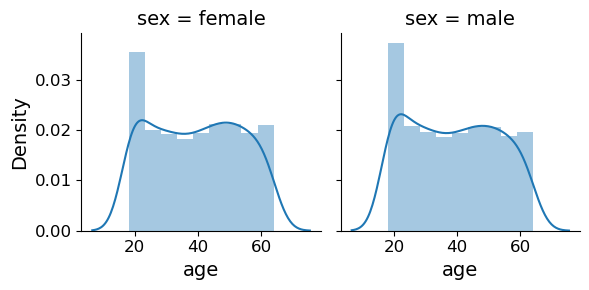

In [339]:
grid = sns.FacetGrid(data_frame, col = 'sex')
grid.map(sns.distplot, 'age')

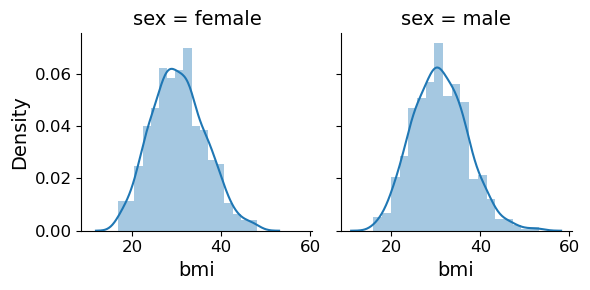

In [340]:
grid = sns.FacetGrid(data_frame, col = 'sex')
grid.map(sns.distplot, 'bmi')

<Axes: xlabel='smoker', ylabel='charges'>

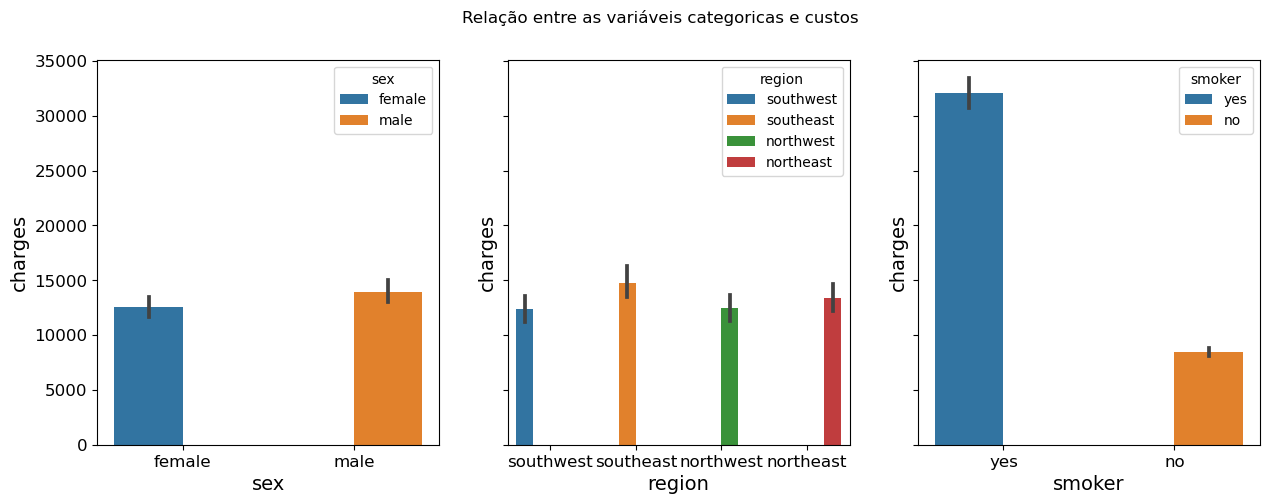

In [341]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('Relação entre as variáveis categoricas e custos')
sns.barplot(x='sex', y= 'charges', hue="sex", data=data_frame, ax=axes[0])
sns.barplot(x='region', y= 'charges', hue="region", data=data_frame, ax=axes[1])
sns.barplot(x='smoker', y= 'charges', hue="smoker", data=data_frame, ax=axes[2])

<Axes: xlabel='sex', ylabel='charges'>

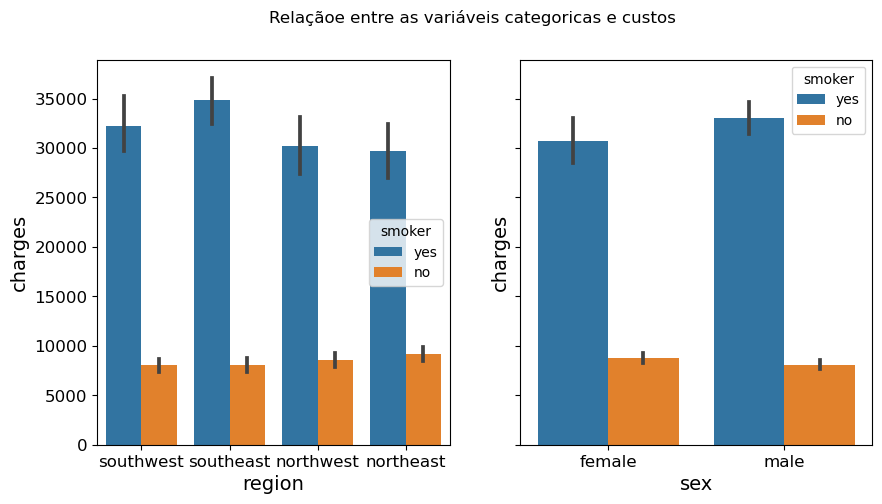

In [342]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.suptitle('Relaçãoe entre as variáveis categoricas e custos')
sns.barplot(x='region', y= 'charges', hue='smoker', data=data_frame, ax=axes[0])
sns.barplot(x='sex', y= 'charges', hue='smoker', data=data_frame, ax=axes[1])


Analisando as variáveis categórias e custo podemos perceber que as pessoas que fumam tendem a ter valores maiores de seguro saúde. Região e sexo parecem ter um valor de custo mais distribuídos

In [343]:
# Descrição dos dados numéricos
data_frame.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


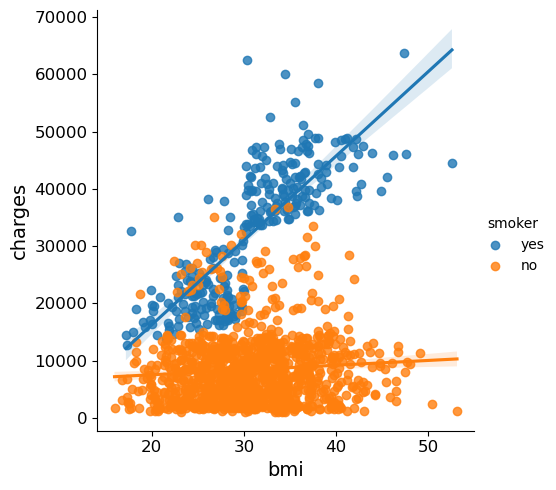

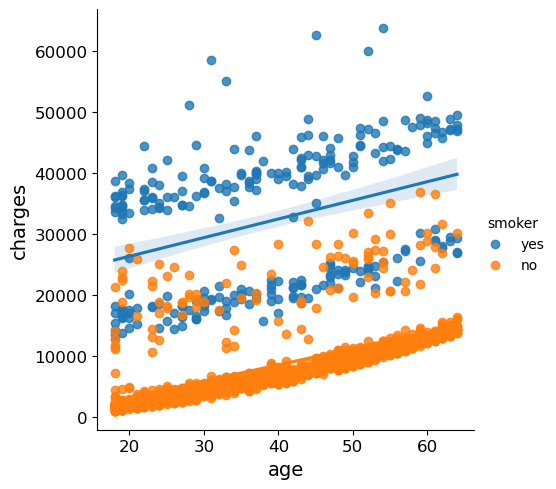

In [344]:
sns.lmplot(x='bmi', y='charges', data=data_frame, hue='smoker')
sns.lmplot(x='age', y= 'charges', data=data_frame, hue='smoker')

Analisando os dados numéricos podemos ver um relação entre o custo do seguro saúde com o bmi (indice de massa corporea) e se a pessoa fuma ou não. Podemos ver que Os custos são maiores entre fumantes com maior bmi. Já os não fumantes com com alto bmi tem um custo de seguro mais baixo.

Também podemos perceber que o fato da pessoa fumar também pressiona o custo com o aumento a idade

A relação entre tabagismo e a quantidade de filhos não aparenta aumentar custo, bem como o numero de filhos também não apresenta uma forte relação com o aumento de custo

In [345]:
# Vamos utilizar a tecnica de label encoder para transformar as variáveis categóricas em valores numéricos e criar um histograma com a distribuição dos dados
from sklearn.preprocessing import LabelEncoder

df_exploratorio = data_frame.copy()

label_encoder = LabelEncoder()

df_exploratorio['sex'] = label_encoder.fit_transform(df_exploratorio['sex'])
df_exploratorio['smoker'] = label_encoder.fit_transform(df_exploratorio['smoker'])
df_exploratorio['region'] = label_encoder.fit_transform(df_exploratorio['region'])

df_exploratorio.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [346]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df_exploratorio.drop(['charges'], axis=1)
y = df_exploratorio['charges']

normalized_X = scaler.fit_transform(X)

normalized_X = pd.DataFrame(normalized_X, columns=X.columns)
y = y.reindex(normalized_X.index, method='ffill')

pd.DataFrame(normalized_X)

results = sm.OLS(y, normalized_X).fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.063
Model:                            OLS   Adj. R-squared (uncentered):              0.059
Method:                 Least Squares   F-statistic:                              15.01
Date:                Sat, 25 May 2024   Prob (F-statistic):                    1.13e-16
Time:                        14:12:31   Log-Likelihood:                         -14950.
No. Observations:                1337   AIC:                                  2.991e+04
Df Residuals:                    1331   BIC:                                  2.994e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Vamos buscar agora as correlações

In [347]:
df_exploratorio.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.019814,0.109344,0.041536,-0.025587,0.001626,0.298308
sex,-0.019814,1.000000,0.046397,0.017848,0.076596,0.004936,0.058044
bmi,0.109344,0.046397,1.000000,0.012755,0.003746,0.157574,0.198401
children,0.041536,0.017848,0.012755,1.000000,0.007331,0.016258,0.067389
smoker,-0.025587,0.076596,0.003746,0.007331,1.000000,-0.002358,0.787234
region,0.001626,0.004936,0.157574,0.016258,-0.002358,1.000000,-0.006547
charges,0.298308,0.058044,0.198401,0.067389,0.787234,-0.006547,1.000000


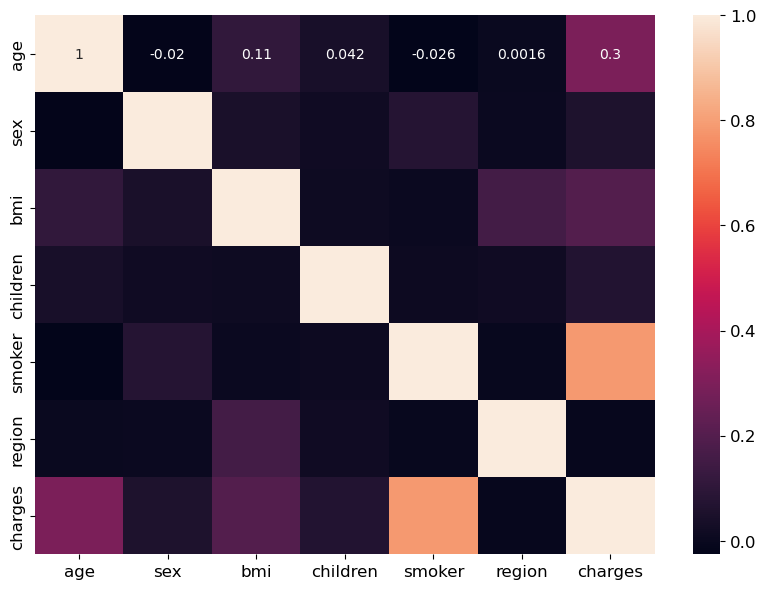

In [348]:
plt.figure(figsize=(10,7))
sns.heatmap(df_exploratorio.corr(), annot = True)
plt.show()

Quão mais claro, mais forte a relação entre uma variável com a nossa target ("charges").

Como esperado, tabagismo tem a mais forte de todas as relações seguido pela idade e o índice de massa corporal.

Nesse caso podemos dizer que region, sex e children possuem os menores níveis de relacionamento

### Resumo

- Nossos campos são:  age,sex,bmi,children,smoker,region,charges das quais smoker, sex e region são variáveis categóricas
- Os dados não apresentam valores nulos
- Foram retirados as entradas duplicadas
- Idade esta bem distribuída entre homens e mulheres
- O índice de massa corporal (BMI) entre homens e mulheres aparentam estar bem distribuído
- Temos bem mais não fumantes que não fumantes (smoker) 
- Baseada na ánalise do P-value, smoker e age são as variáveis com mais significado estatístico para a nossa análise
- Analisando as correlações, smoker, age, tem uma relação mais forte com charges. 

## Preparando as variáveis para treinamento

Os dados selecionado para participar do nosso lado X são smoker, bmi, age. O nosso lado Y será composto apenas da variável target.

In [349]:
data_frame['smoker'] = label_encoder.fit_transform(data_frame['smoker'])
data_frame['sex'] = label_encoder.fit_transform(data_frame['sex'])
data_frame['region'] = label_encoder.fit_transform(data_frame['region'])

In [350]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X = data_frame.drop(['smoker'], axis=1)
y = data_frame['smoker']

# Gerando dados 
X_resampled, y_resampled = smote.fit_resample(X, y)
data_frame = X_resampled
data_frame['smoker'] = y_resampled

In [351]:
# Show smoker new value
data_frame['smoker'].value_counts()

smoker
1    1063
0    1063
Name: count, dtype: int64

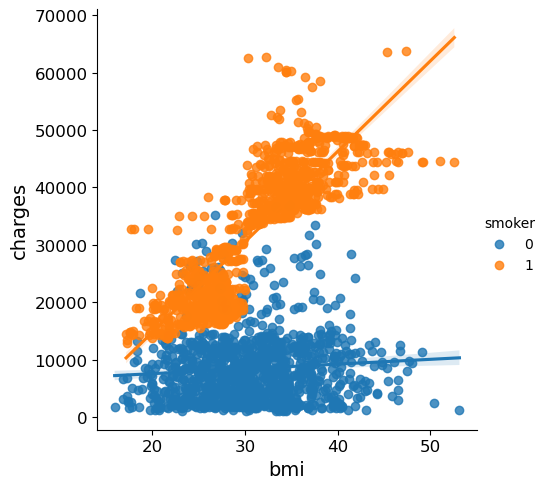

In [352]:
sns.lmplot(x='bmi', y='charges', data=data_frame, hue='smoker')

In [353]:
from sklearn.model_selection import train_test_split

X = data_frame.drop('charges', axis=1)
y = data_frame['charges']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(1700, 6) (426, 6)


In [355]:
def statistic_analyse(degree):

    scaler = PolynomialFeatures(degree=degree)

    data_X = data_frame.drop(['charges'], axis=1)
    data_y = data_frame['charges']

    normalized_X = scaler.fit_transform(data_X)
    normalized_X = pd.DataFrame(normalized_X)

    data_y = data_y.reindex(normalized_X.index, method='ffill')

    pd.DataFrame(normalized_X)

    results = sm.OLS(data_y, normalized_X).fit()

    print(results.summary())

In [356]:
def get_best_degree_pf(model, range, X, y):
  np.random.seed(42)

  pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('model', model)
  ])

  param_grid = {
    'poly__degree': range
  }

  grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

  x_copy = X.copy()
  y_copy = y.copy()

  grid_search.fit(x_copy, y_copy)

  best_degree = grid_search.best_params_['poly__degree']
  print(f"Best degree for {model.__class__.__name__}:", best_degree)

  best_score = -grid_search.best_score_
  print(f"Best score for {model.__class__.__name__}:", best_score)

  mse = -grid_search.cv_results_['mean_test_score']

  plt.plot(range, mse)
  plt.xlabel('Degree')
  plt.ylabel(f'Mean Squared Error {model.__class__.__name__}')
  plt.title('Mean Squared Error vs. Polynomial Degree')
  plt.show()
  print(" ")

In [357]:
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model_results = OrderedDict()

def rmse(test, pred):
    return np.sqrt(mean_squared_error(test, pred)) 
    
def r2(test, pred):
    return r2_score(test, pred) 

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validation(test,pred, name):
    model_results[name] = (name, rmse(test, pred), r2(test, pred), calculate_mape(test, pred))
    

## Treinando Modelo de Regressão Linear

Best degree for LinearRegression: 3
Best score for LinearRegression: 23153702.883727595


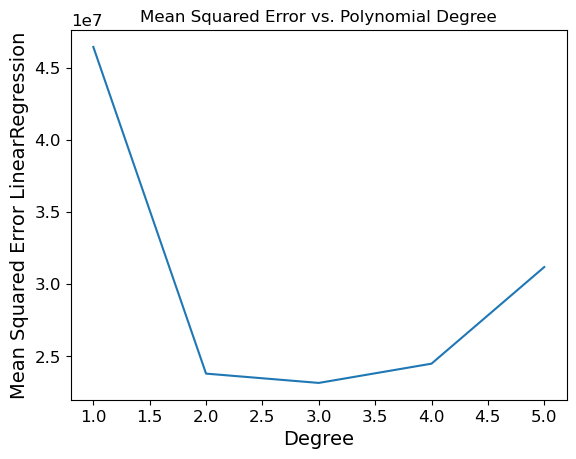

In [358]:
get_best_degree_pf(LinearRegression(), (np.arange(1, 6)), x_train, y_train)

In [359]:
poly_linear_regration = PolynomialFeatures(degree=3, include_bias=False)
x_train_linear_regration = poly_linear_regration.fit_transform(x_train.copy())
x_test_linear_regration = poly_linear_regration.fit_transform(x_test.copy())

In [360]:
statistic_analyse(3)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     294.8
Date:                Sat, 25 May 2024   Prob (F-statistic):               0.00
Time:                        14:12:32   Log-Likelihood:                -20907.
No. Observations:                2126   AIC:                         4.195e+04
Df Residuals:                    2056   BIC:                         4.235e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0           7.755e+04   1.11e+04      7.012      0.0

In [361]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_linear_regration, y_train)
predictions_linear_regration = lin_reg.predict(x_test_linear_regration)

validation(y_test,predictions_linear_regration, "Regressão Linear")

## Treinando Modelo de Arvore de Decisão

Best degree for DecisionTreeRegressor: 1
Best score for DecisionTreeRegressor: 30301113.261935987


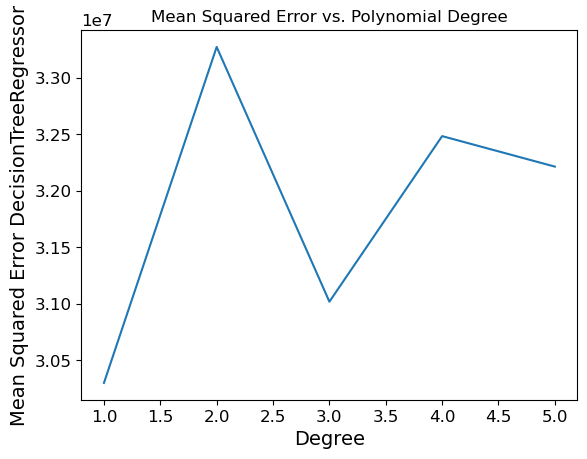

In [362]:
get_best_degree_pf(DecisionTreeRegressor(), (np.arange(1, 6)), x_train, y_train)

In [363]:
poly_decision_tree = PolynomialFeatures(degree=1, include_bias=False)
x_train_decision_tree = poly_decision_tree.fit_transform(x_train.copy())
x_test_decision_tree = poly_decision_tree.fit_transform(x_test.copy())

In [364]:
statistic_analyse(1)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1389.
Date:                Sat, 25 May 2024   Prob (F-statistic):               0.00
Time:                        14:12:33   Log-Likelihood:                -21749.
No. Observations:                2126   AIC:                         4.351e+04
Df Residuals:                    2119   BIC:                         4.355e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0          -2.553e+04    850.801    -30.004      0.0

In [365]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(x_train_decision_tree, y_train)
predictions_decision_tree = decision_tree.predict(x_test_decision_tree)

validation(y_test, predictions_decision_tree, "Árvore de Decisão")

## Treinando Modelo RandomForestRegressor

Best degree for RandomForestRegressor: 5
Best score for RandomForestRegressor: 18155183.525907423


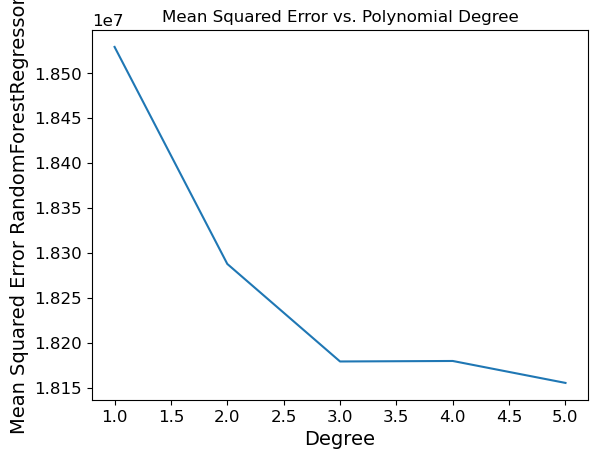

In [366]:
get_best_degree_pf(RandomForestRegressor(n_estimators=100, random_state=42), (np.arange(1, 6 )), x_train, y_train)

In [367]:
poly_random_forest = PolynomialFeatures(degree=4, include_bias=False)
x_train_random_forest = poly_random_forest.fit_transform(x_train.copy())
x_test_random_forest = poly_random_forest.fit_transform(x_test.copy())

In [368]:
statistic_analyse(4)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     146.6
Date:                Sat, 25 May 2024   Prob (F-statistic):               0.00
Time:                        14:13:38   Log-Likelihood:                -20771.
No. Observations:                2126   AIC:                         4.185e+04
Df Residuals:                    1972   BIC:                         4.272e+04
Df Model:                         153                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0           1.223e+05    4.6e+04      2.658      0.0

In [369]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train_random_forest, y_train)
predictions = rf.predict(x_test_random_forest)

validation(y_test, predictions, "Random Forest")

## Análise de Resultado

In [370]:
### Tabulando os resultados
from tabulate import tabulate

table = []
table.append(['S.No.', 'Classification Model', 'Root Mean Squared Error', 'R-squared', 'MAPE'])
count = 1

for key, value in model_results.items():
    row = [count, value[0], value[1], value[2],value[3]]
    table.append(row)
    count += 1
    
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════╤════════════════════════╤═══════════════════════════╤═════════════╤═════════╕
│   S.No. │ Classification Model   │   Root Mean Squared Error │   R-squared │    MAPE │
╞═════════╪════════════════════════╪═══════════════════════════╪═════════════╪═════════╡
│       1 │ Regressão Linear       │                   4478.56 │    0.912711 │ 25.5752 │
├─────────┼────────────────────────┼───────────────────────────┼─────────────┼─────────┤
│       2 │ Árvore de Decisão      │                   5249.72 │    0.880062 │ 27.0784 │
├─────────┼────────────────────────┼───────────────────────────┼─────────────┼─────────┤
│       3 │ Random Forest          │                   3977.8  │    0.931139 │ 22.3162 │
╘═════════╧════════════════════════╧═══════════════════════════╧═════════════╧═════════╛


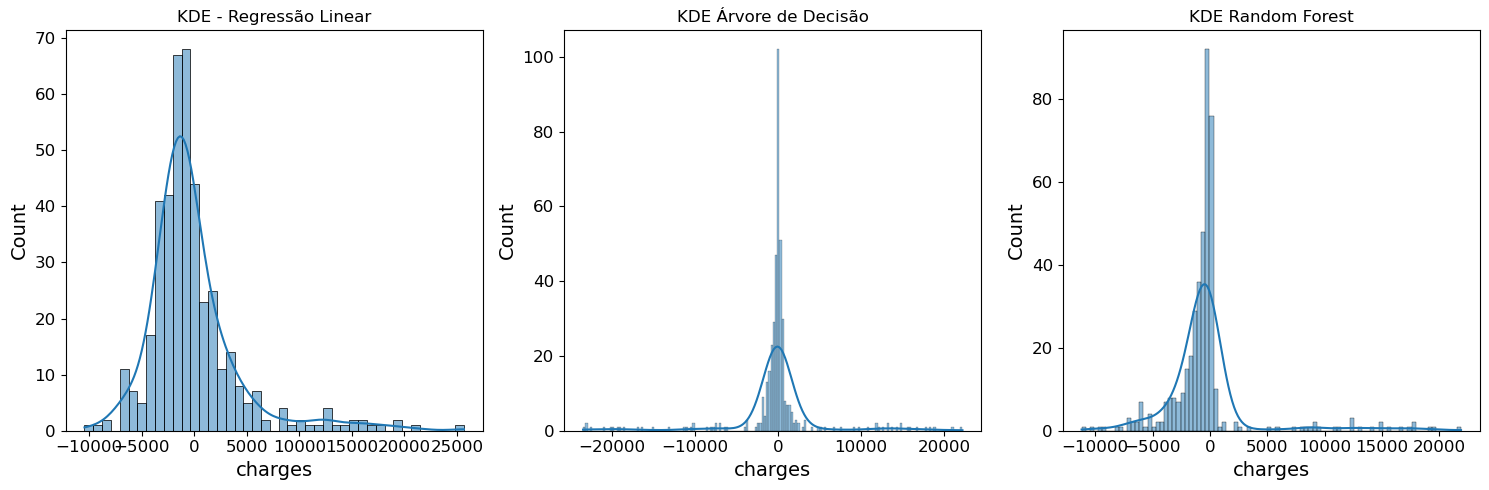

In [371]:
residuals_linear = y_test - predictions_linear_regration
residuals_decision_tree = y_test - predictions_decision_tree
residuals_random = y_test - predictions

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(residuals_linear, ax=axes[0], fill=True, kde=True)
axes[0].set_title('KDE - Regressão Linear')

sns.histplot(residuals_decision_tree, ax=axes[1], fill=True, kde=True)
axes[1].set_title('KDE Árvore de Decisão')

sns.histplot(residuals_random, ax=axes[2], fill=True, kde=True)
axes[2].set_title('KDE Random Forest')

plt.tight_layout()
plt.show()

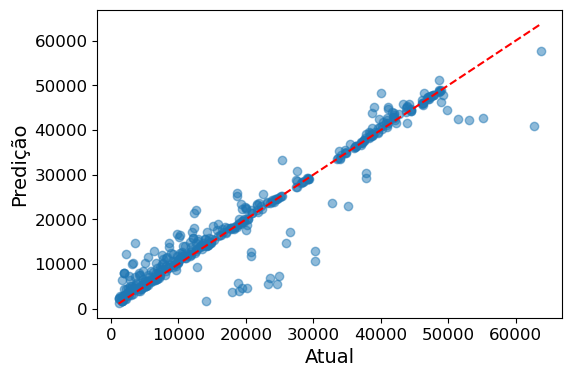

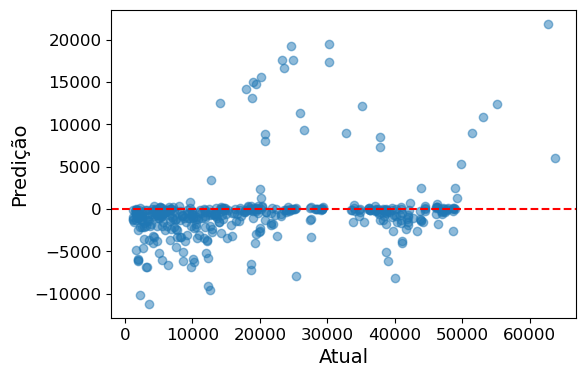

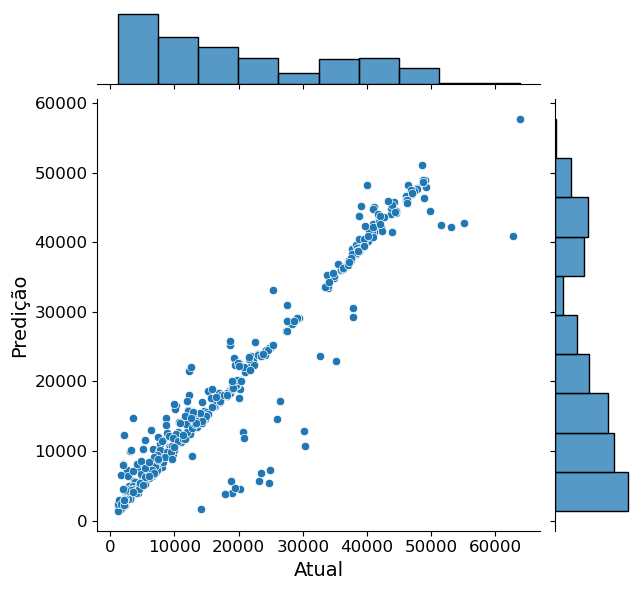

In [372]:
# Gráfico 2
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Line of perfect prediction
plt.xlabel("Atual")
plt.ylabel("Predição")
plt.show()

# Gráfico 4
difference = y_test - predictions
plt.figure(figsize=(6, 4))
plt.scatter(y_test, difference, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Atual")
plt.ylabel("Predição")
plt.show()

# Gráfico 5
sns.jointplot(x=y_test, y=predictions, kind='scatter', height=6)
plt.xlabel("Atual")
plt.ylabel("Predição")
plt.show()

